In [31]:
import pandas as pd

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import pmdarima as pm

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import seaborn as sns

<h2>Просмотр данных</h2>

In [2]:
raw = pd.read_csv('AirPassengers.csv')

In [3]:
raw

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [4]:
# есть additive и multiplicative модели
# additive - когда тренд относительно стабилен
# multiplicative - когда тренд увеличивается со временем
# по умолчанию стоит additive
# в нашем случае тренд стабилен, он увеличивается с одинаковым темпом, поэтому additive
result = seasonal_decompose(raw['#Passengers'], model='additive',
                            period=12
                           )

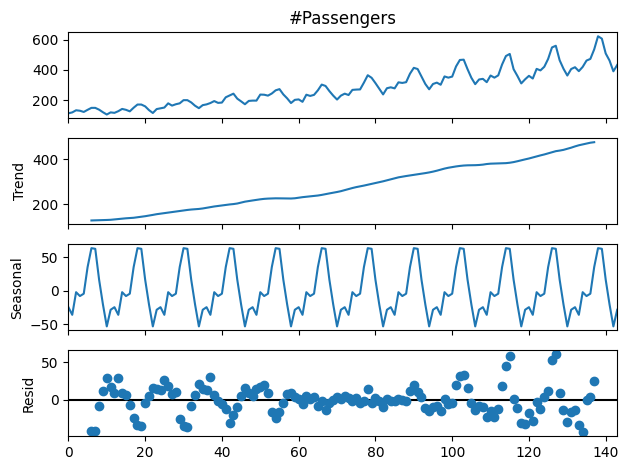

In [5]:
result = result.plot()

<h2>Подбор параметров руками</h2>

In [6]:
# p-value > 0.05, ряд НЕ стационарен
adfuller(raw['#Passengers'])[1]

0.991880243437641

In [7]:
# если сделать разницу с предыдущим значением
# все равно немного нестационарен
adfuller(raw['#Passengers'].diff(1).dropna())[1]

0.0542132902838255

In [8]:
# но на 2 значения назад (не третий минус второй минус первый, а третий минус первый)
# то ряд становится стационарным
adfuller(raw['#Passengers'].diff(2).dropna())[1]

0.03862975767698839

In [9]:
# это означает, что нам нужно значение d равное 1 или 2

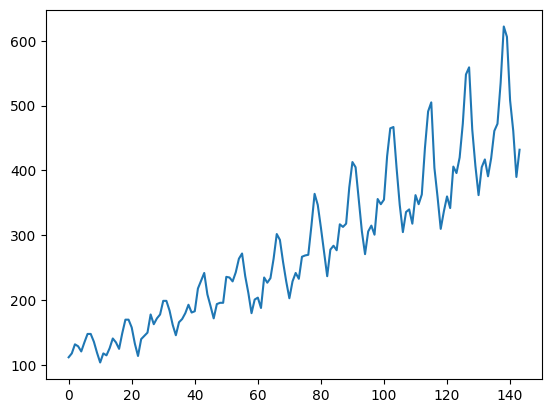

In [10]:
plot = raw['#Passengers'].plot()

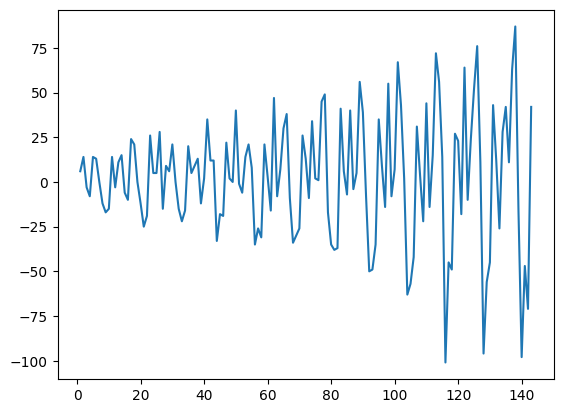

In [11]:
plot = raw['#Passengers'].diff(1).dropna().plot()

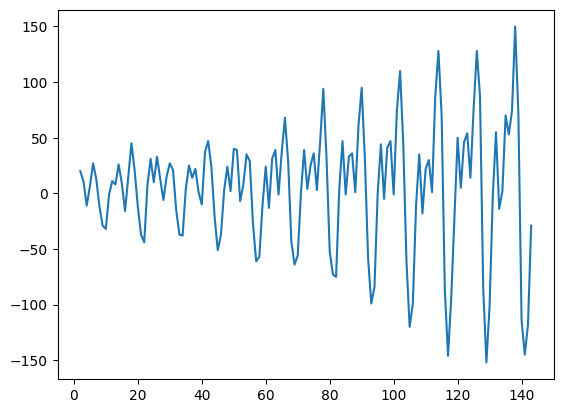

In [12]:
plot = raw['#Passengers'].diff(2).dropna().plot()

<h3>Чтобы определить параметры вручную:
    <li>Для AR используется pacf</li>
    <li>Для MA используется acf</li>
</h3>

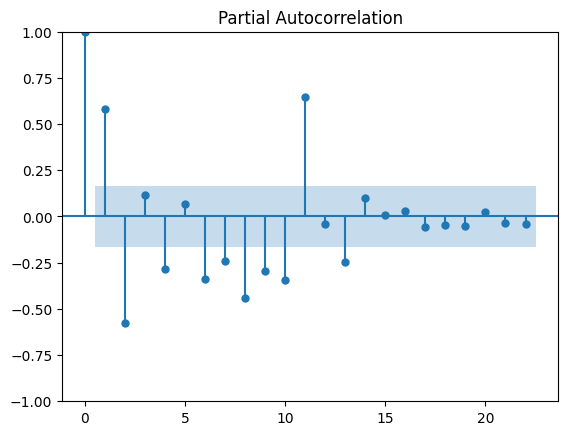

In [13]:
# построим pacf для AR части ARIMA модели и определения оптимального p

# значимы 1, 2 и 12 лаги
# то есть нам подойдет AR(1) или AR(2)

# но у нас значим 12 лаг, то есть наблюдается сильная годичная сезонность каждые 12 месяцев
# здесь не нужно AR(12), а нужно включать сезонный компонент
# значит, нам нужна SARIMA
plot = plot_pacf( raw['#Passengers'].diff(2).dropna())

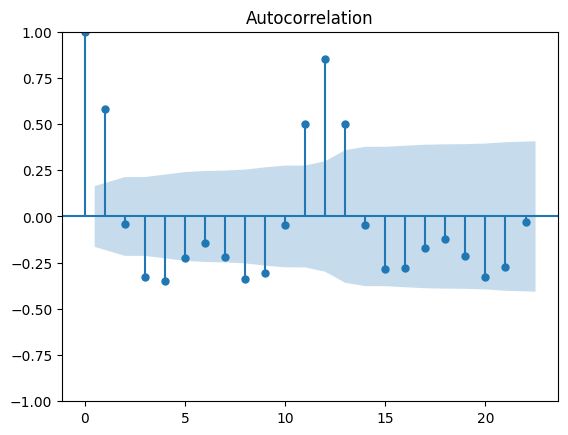

In [14]:
# По acf смотрим MA параметр
# здесь значимы 1, 2 и 12-14
# то есть нам подойдёт AR(1) или AR(2)

plot = plot_acf( raw['#Passengers'].diff(2).dropna())

<h2><center>Учимся не не всех данных</center></h2>

In [46]:
# определим длины
train_len = int(raw.shape[0] * 0.7)
test_len = raw.shape[0] - train_len

In [47]:
# есть правило, что d + D не должно быть больше 2 (правда ли это?)
# 12 - сезонность, у нас 12 месяцев
# Сезонность считается только внутри года: раз в 4 месяца, раз в 12 месяцев (правда ли это?)
# я поигрался с параметрами и пришёл к следующей модели
# все p-value значимы

# то есть это модель AR(2), I(1) - для стационарности, MA(1)
# сезонная m = 12, так как у нас месяцы
# сезонные: AR(1) - то есть у нас AR модель от 1 прошлого периода на 12 месяцев назад
# I(1) - то есть из текущего вычитаем значение 12 месячной давности: цель аналогична - достижение стационарности ряда,
# так как у нас сезонность + повышающийся тренд, что приводит к нестационарности ряда из-за сезонности
# мы с нестационарностью боремся при помощи d=1 + D=1, один несезонный, другой сезонный
# MA(2) - то есть мы берём 2 ошибки из 2 периодов: на 12 и 24 месяца назад

model = ARIMA(raw['#Passengers'][:train_len], order=(2, 1, 1),
             seasonal_order=(1, 1, 2, 12)
             ).fit()
model.summary()

C:\Users\vir\Envs\vlad\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\vir\Envs\vlad\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.

C:\Users\vir\Envs\vlad\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning:

Non-invertible starting seasonal moving average Using zeros as starting parameters.

C:\Users\vir\Envs\vlad\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                           #Passengers   No. Observations:                  100
Model:             ARIMA(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -315.053
Date:                               Thu, 09 May 2024   AIC                            644.106
Time:                                       13:01:12   BIC                            661.367
Sample:                                            0   HQIC                           651.057
                                               - 100                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.2610      0.123    -10.291      0.000      -1.501      -1.021
ar.L2         -0.3168      0.095     -3.319      0.001      -0.504      -0.130
ma.L1          0.9756      0.077     12.636      0.000       0.824       1.127
ar.S.L12       0.9996      0.335      2.980      0.003       0.342       1.657
ma.S.L12      -1.5237     12.225     -0.125      0.901     -25.484      22.437
ma.S.L24       0.5368      6.346      0.085      0.933     -11.901      12.974
sigma2        62.5276    744.368      0.084      0.933   -1396.406    1521.461
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                 3.07
Prob(Q):                              0.83   Prob(JB):                         0.22
Heteroskedasticity (H):               1.33   Skew:                             0.46
Prob(H) (two-sided):                  0.45   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h2>Руками параметры подобраны отлично и AIC равен 1012</h2>

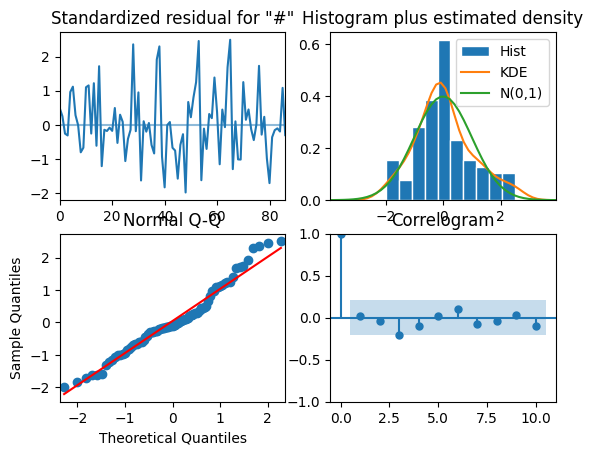

In [48]:
# остатки находятся вокруг 0 и их дисперсия не растёт со временем
# остатки распределены нормальным образом
# QQ в порядке
# Все супер
diagnostics = model.plot_diagnostics()

In [49]:
# предсказываем на 44 периода вперёд
pred = model.forecast(test_len)

<h3>Если нас такой график устраивает, то учим модель на всех данных и уже делаем предсказание в будущее</h3>

<Axes: xlabel='Month', ylabel='#Passengers'>

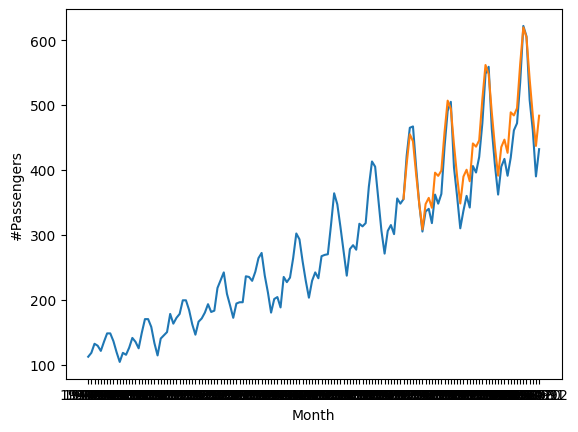

In [51]:
# правильно учить модель вот так перед тем, чтобы что-то делать
sns.lineplot(
    data=raw,
    y='#Passengers',
    x='Month'
)
sns.lineplot(pred)

<h2><center>Теперь учим на всех данных</center></h2>

In [53]:
model = ARIMA(raw['#Passengers'], order=(2, 1, 1),
             seasonal_order=(1, 1, 2, 12)
             ).fit()
model.summary()

C:\Users\vir\Envs\vlad\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

C:\Users\vir\Envs\vlad\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                       
=============================================================================================
Dep. Variable:                           #Passengers   No. Observations:                  144
Model:             ARIMA(2, 1, 1)x(1, 1, [1, 2], 12)   Log Likelihood                -499.042
Date:                               Thu, 09 May 2024   AIC                           1012.085
Time:                                       13:03:57   BIC                           1032.211
Sample:                                            0   HQIC                          1020.263
                                               - 144                                         
Covariance Type:                                 opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5266      0.080      6.590      0.000       0.370       0.683
ar.L2          0.2790      0.084      3.334      0.001       0.115       0.443
ma.L1         -0.9801      0.023    -43.059      0.000      -1.025      -0.935
ar.S.L12       0.9854      0.101      9.788      0.000       0.788       1.183
ma.S.L12      -1.2925      0.328     -3.936      0.000      -1.936      -0.649
ma.S.L24       0.3667      0.152      2.417      0.016       0.069       0.664
sigma2       107.6759     22.288      4.831      0.000      63.992     151.360
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):                16.70
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.72   Skew:                            -0.02
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# делаем предсказание на 50 периодов в будущее
pred = model.forecast(50)

<Axes: ylabel='predicted_mean'>

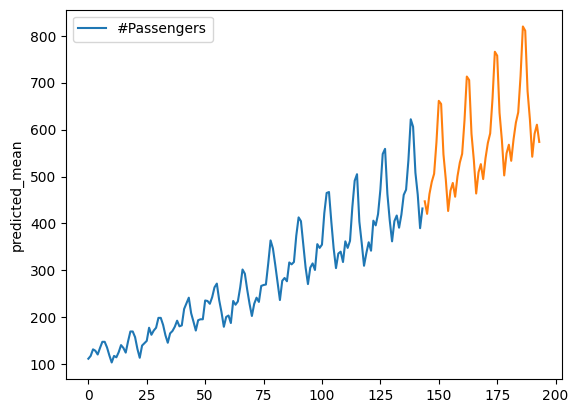

In [57]:
# прогноз в будущее
sns.lineplot(raw)
sns.lineplot(pred)

<h1>Теперь автоматически</h1>

In [25]:
model = pm.auto_arima(raw['#Passengers'],
                      start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=12,              # frequency of series, если m = 1, то сезонность отключается
                      d=None,           # let model determine 'd'
                      seasonal=True,   # Seasonality
                      start_P=0, 
                      D=None,  # модель определит D автоматически
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=1022.896, Time=0.33 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=1031.508, Time=0.02 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=1020.393, Time=0.05 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=1021.003, Time=0.08 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=1020.393, Time=0.03 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=1019.239, Time=0.16 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=0.88 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=1020.493, Time=0.18 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=1032.120, Time=0.10 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=1021.120, Time=0.22 sec
 ARIMA(1,1,1)(2,1,0)[12]             : AIC=1021.032, Time=0.27 sec
 ARIMA(0,1,1)(2,1,0)[12]             : AIC=1019.178, Time=0.16 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=1020.425, Time=0.05 sec
 ARIMA(0,1,1)(2,1,1)[12]             : AIC=inf, Time=0.86 sec
 ARIMA(0,1,1)(1,1,1)[12]     

In [26]:
model.fit(raw['#Passengers'])

ARIMA(order=(0, 1, 1), scoring_args={}, seasonal_order=(2, 1, 0, 12),
      suppress_warnings=True, with_intercept=False)

In [27]:
model = ARIMA(raw['#Passengers'], order=(0, 1, 1),
             seasonal_order=(2, 1, 0, 12)
             ).fit()

In [28]:
pred = model.forecast(50)

In [29]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                       #Passengers   No. Observations:                  144
Model:             ARIMA(0, 1, 1)x(2, 1, [], 12)   Log Likelihood                -505.589
Date:                           Thu, 09 May 2024   AIC                           1019.178
Time:                                   12:57:25   BIC                           1030.679
Sample:                                        0   HQIC                          1023.851
                                           - 144                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3634      0.074     -4.945      0.000      -0.508      -0.219
ar.S.L12      -0.1239      0.090     -1.372      0.170      -0.301       0.053
ar.S.L24       0.1911      0.107      1.783      0.075      -0.019       0.401
sigma2       130.4480     15.527      8.402      0.000     100.016     160.880
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 4.59
Prob(Q):                              0.92   Prob(JB):                         0.10
Heteroskedasticity (H):               2.70   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.87
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<h2>AIC меньше, чем в моей модели + незначим сезонный AR компонент</h2>

<h2>Предсказания тоже отличные</h2>

<Axes: >

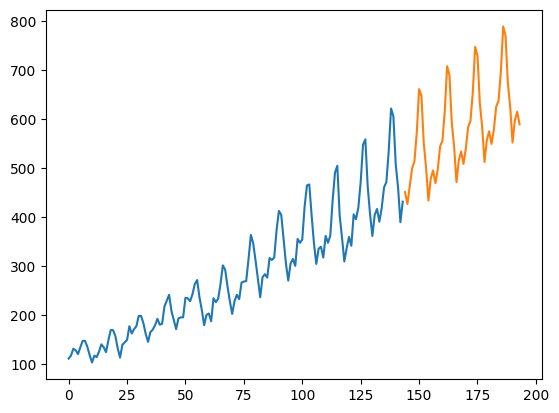

In [30]:
raw['#Passengers'].plot()
pred.plot()

<h2>Что нужно, чтобы сделать multivariative предсказание: то есть использовать не только сам ряд, но и другие влияющие на него параметры</h2>

model = pm.auto_arima(raw[основная колонка],
                      # нужно добавить параметр exogenous
                      exogenous=raw[[нужные_колонки]],  # эти фичи дополнительно будут использоваться при построении модели
                      start_p=1, start_q=1,
                      test='adf',       
                      max_p=3, max_q=3, 
                      m=12,              
                      d=None,
                      seasonal=True, 
                      start_P=0, 
                      D=None,
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

<h3>ВАЖНО: при предсказаниях впоследствии тоже будут нужны включенные при обучении модели дополнительные фичи</h3>